# Improving Retrieval Agent using HyDe Method

We're going to improve at area before searching by generating similar content based on the questions and then comparing to the actual documents.

In [1]:
# Prepare environment variable
# You should check env.example file
# It's needed throughout this jupyter notebook
import os
from dotenv import load_dotenv
load_dotenv()

True

# Retrieval Tool

Creating tools meaning we are only doing what the tools intendeed, let the summarizer by the agent it self

In [32]:
# Prepare library
## AI Search related
import langchain_community.vectorstores.azuresearch as azuresearch
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings

## LLM related
import os
import json
from langchain.chat_models import init_chat_model

## Tool creation related
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage, ToolMessage

## Misc - to improve tool performance
import threading

In [33]:
# Check if you already prepare the environment file
index_name = "kaenova-testing-3" # You can change it, if you want to
api_version = "2024-12-01-preview"
langchain_model_name = "azure_openai:gpt-4" # Adjust based on what you deployed 

for key in ["AZURE_AIS_ENDPOINT", "AZURE_AIS_KEY", "AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_DEPLOYMENT", "AZURE_OAI_CHAT_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [34]:
# !important you may change this. Map the fields into the connector library
azuresearch.FIELDS_CONTENT = "chunk"
azuresearch.FIELDS_CONTENT_VECTOR = "chunk_vector"
azuresearch.FIELDS_ID = "id"

In [35]:
# Prepare the embedding function
embeddings : AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_deployment=os.getenv("AZURE_OAI_DEPLOYMENT"),
    openai_api_version=api_version,
    azure_endpoint=os.getenv("AZURE_OAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OAI_KEY"),
)

embeddings_function = embeddings.embed_query

In [36]:
# Create Azure AI Search client
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=os.getenv("AZURE_AIS_ENDPOINT"),
    azure_search_key=os.getenv("AZURE_AIS_KEY"),
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

In [37]:
# Prepare LLM for query Expander
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OAI_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = api_version

chat_llm = init_chat_model(
    langchain_model_name,
    azure_deployment=os.environ["AZURE_OAI_CHAT_DEPLOYMENT"],
)

In [ ]:
# Define the steps of retrieval flow
def expand_query(questions: str) -> list[str]:
    system_prompt = (
        "You're a search query expander, you'll get a user question and you need to create multiple concise, keyworded, and general search query"
        "That'll be injected to the Azure AI Search"
        "The document is mainly in Indonesian"
        "Return the question only in JSON array without any codeblocks"
        "You'll only return like \'[\"query_1\", \"query_2\", \"query_3\", \"query_4\", \"query_5\"]\'"
    )

    valid = False
    data = []
    while not valid:
        result = chat_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=questions)])
        print("[expand_query] llm_result", result.content)
        
        try:
            data = json.loads(result.content)
            if type(data) is list:
                valid = True
        except:
            print("[expand_query] not a valid value")

    return data

# New! Creating hypothetical documents
def hypothetical_query(questions:str) -> list[str]:
    system_prompt = (
        "You're an answerer to a questions, make a hypothetical multiple short answer. The documents mainly in Indonesian. Make the answer a general short complete sentence."
        "That'll be injected to the Azure AI Search"
        "Return the answer only in JSON array without any codeblocks"
        "You'll only return like \'[\"query_1\", \"query_2\", \"query_3\", \"query_4\", \"query_5\"]\'"
    )

    valid = False
    data = []
    while not valid:
        result = chat_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=questions)])
        print("[hypothetical_query] llm_result", result.content)
        
        try:
            data = json.loads(result.content)
            if type(data) is list:
                valid = True
        except:
            print("[hypothetical_query] not a valid value")

    return data

def unique_dicts(list_of_dicts):
    """
    Returns a unique list of dictionaries based on the 'id' key.

    Args:
        list_of_dicts: A list of dictionaries.

    Returns:
        A new list containing only the unique dictionaries.
    """
    unique_ids = set()
    unique_list = []
    for d in list_of_dicts:
        if d['id'] not in unique_ids:
            unique_ids.add(d['id'])
            unique_list.append(d)
    return unique_list


def retrieve_documents(questions: list[str]) -> list[dict]:
    retrieved_chunks = []
    lock = threading.Lock()

    def search_and_store(question):
        answers = vector_store.semantic_hybrid_search(query=question, k=3)
        local_chunks = [
            {"id": x.metadata['id'], "content": x.page_content}
            for x in answers
        ]
        with lock:
            retrieved_chunks.extend(local_chunks)

    threads = []
    for question in questions:
        thread = threading.Thread(target=search_and_store, args=(question,))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    final_chunks = unique_dicts(retrieved_chunks)
    return final_chunks


In [45]:
# Creating the tool itself

@tool
def retrieve_tool(questions: str) -> list[str]:
    """Tool to retrieve document based on the questions related. This will return a json of related documents. Mainly this is a Indonesian Document, so your questions should be in Indonesian."""
    generated_questions = expand_query(questions)
    hypothetical_answers = hypothetical_query(questions)
    data = retrieve_documents(generated_questions + hypothetical_answers)
    print("[retrieve_tool]", str(data))
    tool_output = "Chunk Data\n```"
    for x in data:
        tool_output += f"\n<data><id>{x["id"]}</id><chunk>{x["content"]}</chunk>/data>"
    tool_output += "\n```"
    return tool_output

In [47]:
# Let's try the tool first
print(retrieve_tool("Kapan Gerakan perempuan?")[:1])

[expand_query] llm_result ["gerakan perempuan tanggal", "sejarah gerakan perempuan", "gerakan feminis timeline", "perkembangan gerakan perempuan", "milestones gerakan feminis"]
[hypothetical_query] llm_result ["Gerakan perempuan mulai muncul di Indonesia pada awal abad ke-20", "Gerakan perempuan mengalami kemajuan signifikan setelah kemerdekaan Indonesia", "Gerakan perempuan bertujuan untuk memperjuangkan kesetaraan dan keadilan gender"]


Exception in thread Thread-39 (search_and_store):
Traceback (most recent call last):
  File "/Users/mymac/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/Users/mymac/.cache/uv/archive-v0/lv37PuXbW9hg5BbsAuAcy/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/Users/mymac/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/03/74z6gldj3tl9q5x76cxxngl40000gn/T/ipykernel_89687/2192689258.py", line 73, in search_and_store
  File "/Users/mymac/Development/learn-rag-agentic/.venv/lib/python3.12/site-packages/langchain_community/vectorstores/azuresearch.py", line 1276, in semantic_hybrid_search
    docs_and_scores = self.semantic_hybrid_search_with_score_and_rerank(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^

[retrieve_tool] [{'id': '75f218c9a1341be9b298ed3848d7c055__chunk_0045', 'content': 'banyak kelompok yang memiliki massa, baik yang berbasis ideologi \npolitik maupun agama. Kekuatan kelompok tersebut memunculkan warna \nyang beragam pada identitas nasional dan berbagai peristiwa sejarah di \nIndonesia. Beberapa di antaranya akan dibahas pada subbab berikut.\n1.\t Gerakan Perempuan \nGerakan Perempuan pada tahun 1950—1960 merupakan salah satu \nperiode pergerakan paling progresif setelah tahun 1928. Pada periode ini \nbanyak organisasi perempuan yang berafiliasi dengan kekuatan-kekuatan \norganisasi massa yang besar. Sebagai contoh Aisyiah dari Muhammadiyah, \nMuslimat dari Masyumi, Muslimat Nahdlatul Ulama (NU) dari NU, Perwari, \ndan juga Gerakan Wanita Istri Sedar (Gerwis). Gerwis merupakan gabungan \ndari ratusan aktivis dan berbagai organisasi perempuan, misalnya Rukun \nPutri Indonesia, Persatuan Wanita Sedar, Isteri Sedar, Gerakan Wanita \nIndonesia, dan Perjuangan Putri Republik

# Create langgraph chat agent

In [48]:
# Prepare library
## LLM related
import os
import json
from langchain.chat_models import init_chat_model

## State related
from typing import Annotated, Literal
from typing_extensions import TypedDict

## Graph Related
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

## Graph Related Memory
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [49]:
# Check if you already prepare the environment file
api_version = "2024-12-01-preview"
langchain_model_name = "azure_openai:gpt-4" # Adjust based on what you deployed 

for key in ["AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_CHAT_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [50]:
# Prepare langgraph state 
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # To keep chat threads

In [56]:
# Prepare Graph
## Prepare langgraph llm initialization
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OAI_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = api_version

chat_llm = init_chat_model(
    langchain_model_name,
    azure_deployment=os.environ["AZURE_OAI_CHAT_DEPLOYMENT"],
)

## Prepare tool integration with the llm
tools = [retrieve_tool]
tools_by_name = {tool.name: tool for tool in tools}
chat_llm_with_tools = chat_llm.bind_tools(tools)

## Define Node for LLM
def llm_node(state: State):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            chat_llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=(
                            "You are a helpful assistant that can do retrieval using the retrieval tools."
                            "The retrieval tools helps you to get data. Analyze the user intention and decide wether you need to use tools or not."
                            "When retrieving documents, cite the document id as link with the cite number"
                        )
                    )
                ]
                + state["messages"]
            )
        ],
    }

## Define Node for Tool Calling
def retrieve_tool_node(state: State):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


## Define Condition when to use tools
def llm_node_conditions(state: State) -> Literal["retrieve_tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "retrieve_tool_node"
    # Otherwise, we stop (reply to the user)
    return END

In [57]:
# Build Graph
## Prepare Graph Builder
graph_builder = StateGraph(State)

## Add nodes
graph_builder.add_node("llm_node", llm_node)
graph_builder.add_node("retrieve_tool_node", retrieve_tool_node)

## Add edges
graph_builder.add_edge(START, "llm_node")
graph_builder.add_conditional_edges(
    "llm_node",
    llm_node_conditions,
    ["retrieve_tool_node", END]
)
graph_builder.add_edge("retrieve_tool_node", "llm_node")

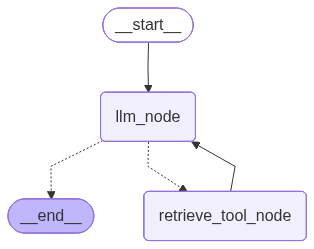

In [58]:
# Compile Graph w/ Saving the State

## Prepare Database for Saving the state (checkpoint)
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

## Prepare the graph
graph = graph_builder.compile(checkpointer=memory)

display(graph)

# Let's Chat w/ Tools

In [59]:
def stream_chat(chat_id: str):
    config = {"configurable": {"thread_id": chat_id}}
    while True:
        user_input = input("> ")
        if user_input in ["q", "quit", "\\q"]:
            print("Goodbye!")
            break
        messages = [HumanMessage(content=user_input)]
        for chunk in graph.stream({"messages": messages}, stream_mode="updates", config=config):
            print(chunk)
            print("\n")

In [60]:
## Prepare the graph session for the checkpoint
chat_id = "unique-id-07"
stream_chat(chat_id)

>  What's my first questions?


{'llm_node': {'messages': [AIMessage(content='Your first question was "Halo!" which is a greeting in Indonesian.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 25148, 'total_tokens': 25164, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGtBEehueD6MLlg0eGey68d5GQ69', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filt

>  No, i mean the questions!


{'llm_node': {'messages': [AIMessage(content='Oh, I see! Your first question was about wanting to find out about Indonesian independence. You asked for a very clear answer on the topic.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 25178, 'total_tokens': 25208, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CGGtRsHdDdnGi0rp6NQJuHcpJB9Ul', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'

>  q


Goodbye!
